In [1]:
import NN_Module_Poly as nnm
import torch
import numpy as np
import numpy.ma as ma
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math
import time
import copy
import pandas as pd
from pandas import read_csv
import argparse
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# Functions
# DEPRECATED
def evaluate_legacy(inputs):
    # Assumes model uses square and cross terms as well as standardization
    # Assumes model takes in 152 terms
    # Currently only uses a slice of inputs_all
    all_shape = list(inputs.shape) # The shape of the final input tensor, including the square and cross terms
    all_shape[-1] = 152
    cross_shape = list(inputs.shape) # The shape of the input cross terms tensor
    cross_shape[-1] = 120
    inputs_all = torch.zeros(all_shape).cuda()
    squares = inputs**2
    cross_terms = torch.zeros(cross_shape).cuda()
    idx = 0
    for i in range(16):
        for j in range(i):
            cross_terms[...,idx] = inputs[...,i] * inputs[...,j]
            idx += 1
    inputs_all[...,0:16] = inputs
    inputs_all[...,16:32] = squares
    inputs_all[...,32:152] = cross_terms
    std_inputs = nnm.affine_transform(inputs_all, input_stats)
    std_outputs = model(std_inputs)
    outputs = nnm.affine_untransform(std_outputs, output_stats)
    
    return outputs

def evaluate(inputs, model, input_stats, output_stats):
    # Assumes model was trained using square and cross terms as well as standardization
    # Assumes model takes in 16 terms and an internal layer calculates the square and cross terms
    # Currently only uses a slice of inputs_all
    std_inputs = nnm.affine_transform(inputs, input_stats)
    std_outputs = model(std_inputs)
    outputs = nnm.affine_untransform(std_outputs, output_stats)

    return outputs

In [3]:
out_file = '6755_13'

In [4]:
names = {}
names['cQei'] = 0
names['cQl3i'] = 1
names['cQlMi'] = 2
names['cbW'] = 3
names['cpQ3'] = 4
names['cpQM'] = 5
names['cpt'] = 6
names['cptb'] = 7
names['ctG'] = 8
names['ctW'] = 9
names['ctZ'] = 10
names['ctei'] = 11
names['ctlSi'] = 12
names['ctlTi'] = 13
names['ctli'] = 14
names['ctp'] = 15

WC_to_analyze_1 = ['cpQ3', 'cpQM', 'cpt', 'cptb', 'cQei', 'ctei', 'ctli', 'ctW'] # The first of the two WCs to graph
WC_to_analyze_2 = ['cbW', 'ctG', 'ctp', 'cQl3i', 'cQlMi', 'ctlTi', 'ctlSi', 'ctZ'] # The second of the two WCs to graph

batch_size = 4096
epochs = 100
random_starting_points = 50 # The number of random starting points to do gradient descent on for each scanned value

In [5]:
save_dict = torch.load(f'./{out_file}_model+.pt')
best_model_state = save_dict['model']
parameters_save = save_dict['parameters']
input_stats = save_dict['input_stats']
output_stats = save_dict['output_stats']

In [6]:
# Check to make sure we're on cuda
input_stats[0].device

device(type='cuda', index=0)

In [7]:
torch.cuda.memory_allocated() / 1e9

0.00497152

In [8]:
parameters_save

{'N': 16,
 'train_size': 49378587,
 'test_size': 498773,
 'hidden_nodes': 750,
 'hidden_layers': 2,
 'batch_size': 1024,
 'n_epochs': 152,
 'learning_rate': 0.0001,
 'lr_red_factor': 0.2,
 'lr_red_patience': 20.0,
 'lr_red_threshold': 1e-06,
 'weight_decay': 0.0,
 'accu_out_resolution': 100,
 'out_residual_resolution': 100}

In [9]:
model = nnm.create_model(parameters_save['N'], 1, parameters_save)
model.load_state_dict(best_model_state)
model.eval()

Sequential(
  (0): PolynomialLayer(
    (monomial_layer): MonomialLayer()
    (linear): Linear(in_features=152, out_features=750, bias=True)
  )
  (1): ReLU()
  (2): Linear(in_features=750, out_features=750, bias=True)
  (3): ReLU()
  (4): Linear(in_features=750, out_features=750, bias=True)
  (5): ReLU()
  (6): Linear(in_features=750, out_features=1, bias=True)
)

In [10]:
actual_frozen_2D_data = {}
actual_profiled_2D_data = {}
model_frozen_2D_data = {}
model_profiled_2D_data = {}

In [11]:
# Just test the first graph
nums = [0,1,2,3,4,5,6,7]

In [12]:
# actual frozen data
for num in nums:
    WC1 = WC_to_analyze_1[num]
    WC2 = WC_to_analyze_2[num]
    loaded = np.load(f'likelihood_{WC1}_{WC2}.npz')
    actual_frozen_2D_data[str(num)] = {WC1: loaded[WC1], WC2: loaded[WC2], 'deltaNLL': loaded['deltaNLL']}
    print (actual_frozen_2D_data[str(num)]['deltaNLL'].min())
    actual_frozen_2D_data[str(num)]['deltaNLL'] -= actual_frozen_2D_data[str(num)]['deltaNLL'].min()
    actual_frozen_2D_data[str(num)]['deltaNLL'] *= 2

-0.06825228
-0.99903536
-0.09825421
-0.00508612
-0.00581771
-0.006350204
-0.0060666674
0.0


In [13]:
# actual profiled data
for num in nums:
    WC1 = WC_to_analyze_1[num]
    WC2 = WC_to_analyze_2[num]
    loaded = np.load(f'likelihood_profiled_{WC1}_{WC2}.npz')
    inputs = np.zeros((loaded['deltaNLL'].shape[0], random_starting_points, 16))
    for key2 in names.keys():
        inputs[...,names[key2]] = loaded[key2][:,np.newaxis] # broadcast into the new axis of random starting points
    actual_profiled_2D_data[str(num)] = {'inputs': inputs, 'deltaNLL': loaded['deltaNLL']}
    actual_profiled_2D_data[str(num)]['deltaNLL'] -= actual_profiled_2D_data[str(num)]['deltaNLL'].min()
    actual_profiled_2D_data[str(num)]['deltaNLL'] *= 2

In [14]:
# model frozen data
for num in nums:
    inputs_y = actual_frozen_2D_data[str(num)][WC_to_analyze_1[num]]
    inputs_x = actual_frozen_2D_data[str(num)][WC_to_analyze_2[num]]
    num_inputs = inputs_y.shape[0]
    inputs = np.zeros((num_inputs, 16))
    inputs[:,names[WC_to_analyze_1[num]]] = inputs_y
    inputs[:,names[WC_to_analyze_2[num]]] = inputs_x

    std_inputs = nnm.affine_transform(torch.from_numpy(inputs).float().cuda(), input_stats)
    std_outputs = torch.full((num_inputs, 1), 100.).cuda() # fill outputs with 100. as a default (decimal to force dtype=float not int)
    inputMiniBatches = torch.split(std_inputs, batch_size)
    batch_idx = 0
    for minibatch in range(len(inputMiniBatches)):
        batch_outputs = model(inputMiniBatches[minibatch])
        std_outputs[batch_idx: batch_idx + batch_outputs.shape[0]] = batch_outputs
        batch_idx += batch_outputs.shape[0]
    outputs = nnm.affine_untransform(std_outputs, output_stats).cpu().detach().numpy().flatten()
    print (outputs.min())
    outputs -= outputs.min()
    outputs *= 2
    model_frozen_2D_data[str(num)] = {WC_to_analyze_1[num]: inputs[:,names[WC_to_analyze_1[num]]], WC_to_analyze_2[num]: inputs[:,names[WC_to_analyze_2[num]]], 'deltaNLL': outputs}

3.4416199
1.6867123
1.385086
3.622654
3.6906662
3.7166958
3.5859928
2.0241241


[ 3.18279624 -9.96666622 -9.89999962 ...  9.83333302  9.89999962
  9.96666622]
Starting 0/22 minibatches.


/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:173: UserWarning: Error detected in ReluBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 668, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/usr/lib/python3.8/asyncio

RuntimeError: CUDA out of memory. Tried to allocate 586.00 MiB (GPU 0; 22.17 GiB total capacity; 6.64 GiB already allocated; 159.94 MiB free; 7.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

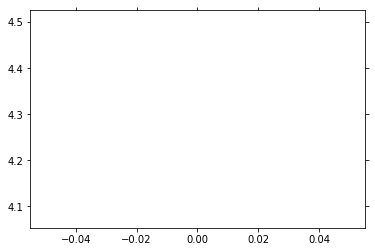

In [15]:
# model profiled data
for num in nums:
    torch.autograd.set_detect_anomaly(True)
    inputs_old = actual_profiled_2D_data[str(num)]['inputs']
    num_inputs = inputs_old.shape[0]
    model_profiled_2D_data[str(num)] = {WC_to_analyze_1[num]: inputs_old[..., 0, names[WC_to_analyze_1[num]]], WC_to_analyze_2[num]: inputs_old[..., 0, names[WC_to_analyze_2[num]]]}
    print (model_profiled_2D_data[str(num)][WC_to_analyze_2[num]])
    inputs = (np.random.random_sample(inputs_old.shape) - 0.5) * 40
    inputs[...,names[WC_to_analyze_1[num]]] = inputs_old[...,names[WC_to_analyze_1[num]]] # copy over the WC being scanned, while leaving the other 15 randomized
    inputs[...,names[WC_to_analyze_2[num]]] = inputs_old[...,names[WC_to_analyze_2[num]]] # copy over the WC being scanned, while leaving the other 15 randomized
    inputs = torch.from_numpy(inputs).float().cuda()
    inputs.requires_grad = True

    outputs = torch.full((num_inputs, 1), 100.).cuda() # fill outputs with 100. as a default (decimal to force dtype=float not int)
    inputMiniBatches = torch.split(inputs, batch_size)
    batch_idx = 0

    start_time = time.perf_counter()

    # Memory debugging info
    memory_fig, memory_ax = plt.subplots()
    memory_count = 0
    memory_count_arr = np.full((len(inputMiniBatches)*epochs), np.NaN)
    memory_vals = np.full((len(inputMiniBatches)*epochs), np.NaN)

    for minibatch in range(len(inputMiniBatches)):
        optimizer = torch.optim.Adam([inputs],lr=1e-0)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=5, threshold=1e-6)
        inputMiniBatches = torch.split(inputs, batch_size)
        batch_inputs = inputMiniBatches[minibatch]
        min_outputs = evaluate(batch_inputs, model, input_stats, output_stats) # The outputs of the random starting points, to be updated every epoch
        min_WCs = batch_inputs.detach().clone() # A snapshot of the WCs of all the points to scan
        optimizer.zero_grad()
        print (f'Starting {minibatch}/{len(inputMiniBatches)} minibatches.')
        for epoch in range(epochs):
            #print (f'Starting {epoch}/{epochs} epochs of {minibatch}/{len(inputMiniBatches)} minibatches.')

            inputMiniBatches = torch.split(inputs, batch_size)
            batch_inputs = inputMiniBatches[minibatch]
            batch_outputs = evaluate(batch_inputs, model, input_stats, output_stats)
            batch_outputs_cp = batch_outputs.detach().clone()
            batch_outputs_sum = torch.sum(torch.log(batch_outputs + 10)) # Optimize the sum of outputs
            idx_to_update = torch.where(batch_outputs_cp < min_outputs)[0]
            min_outputs[idx_to_update] = batch_outputs_cp[idx_to_update]
            min_WCs[idx_to_update] = batch_inputs.detach().clone()[idx_to_update]
            optimizer.zero_grad()
            batch_outputs_sum.backward()
            #print (torch.count_nonzero(inputs.grad))
            #print (inputs.grad)
            #print (inputs.grad[1500,31,6])
            #print (f'Sum of minibatch outputs: {batch_outputs_sum}')
            #print (f'Output of a random point: {batch_outputs[500,0,0]}')
            inputs.grad[...,names[WC_to_analyze_1[num]]] = 0
            inputs.grad[...,names[WC_to_analyze_2[num]]] = 0
            optimizer.step()
            #scheduler.step(output)

            # Memory debugging info
            memory_count_arr[memory_count] = memory_count
            memory_vals[memory_count] = torch.cuda.memory_allocated()/1e9
            memory_ax.cla()
            memory_ax.plot(memory_count_arr, memory_vals)
            memory_count += 1

        (min_outputs_scanned, min_starting_point_indicies) = torch.min(min_outputs, -2) # Get the best all starting points

        # Make the index tensor suitable for gathering the min_WCs
        min_starting_point_indicies = min_starting_point_indicies.unsqueeze(-2)
        min_starting_point_indicies_shape = list(min_starting_point_indicies.shape)
        min_starting_point_indicies_shape[-1] = 16
        min_starting_point_indicies = min_starting_point_indicies.expand(min_starting_point_indicies_shape) # Warning: don't perform in-place operations on this since expand() does not allocate new memory

        min_WCs_scanned = torch.gather(min_WCs, -2, min_starting_point_indicies) # Get the WCs corresponding to the best-performing starting points
        outputs[batch_idx: batch_idx + batch_outputs.shape[0]] = min_outputs_scanned.detach().clone() # detach from graph to delete obsolete graphs from memory! This was the culprit causing the memory leak
        print (WC_to_analyze_1[num] + ' ' + WC_to_analyze_2[num] + ' ' + 'batch number: ' + str(minibatch))
        print (min_WCs_scanned)
        batch_idx += batch_outputs.shape[0]
    print ('Profiling done!')
    print (f'Time used: {time.perf_counter() - start_time} seconds.')
    outputs = outputs.cpu().detach().numpy().flatten()
    outputs -= outputs.min()
    outputs *= 2
    model_profiled_2D_data[str(num)]['deltaNLL'] = outputs

In [ ]:
# diff data
frozen_diff_data = copy.deepcopy(actual_frozen_2D_data)
profiled_diff_data = copy.deepcopy(model_profiled_2D_data) # since actual_profiled_2D_data actually has all 16 variables stored in it
for num in nums:
    frozen_diff_data[str(num)]['deltaNLL'] = model_frozen_2D_data[str(num)]['deltaNLL'] - actual_frozen_2D_data[str(num)]['deltaNLL']
    profiled_diff_data[str(num)]['deltaNLL'] = model_profiled_2D_data[str(num)]['deltaNLL'] - actual_profiled_2D_data[str(num)]['deltaNLL']

In [ ]:
# frozen contours
frozen_contours = {}
for num in nums:
    frozen_contours[str(num)] = plt.subplots()
    actual_contour = frozen_contours[str(num)][1].tricontour(actual_frozen_2D_data[str(num)][WC_to_analyze_2[num]], actual_frozen_2D_data[str(num)][WC_to_analyze_1[num]], actual_frozen_2D_data[str(num)]['deltaNLL'], colors='k', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    model_contour = frozen_contours[str(num)][1].tricontour(model_frozen_2D_data[str(num)][WC_to_analyze_2[num]], model_frozen_2D_data[str(num)][WC_to_analyze_1[num]], model_frozen_2D_data[str(num)]['deltaNLL'], colors='r', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    SM_value = frozen_contours[str(num)][1].scatter(0, 0, marker='d', c='gold', ec='royalblue', s=30, linewidths=1, zorder=10)
    frozen_contours[str(num)][1].legend(actual_contour.collections+model_contour.collections+[SM_value], ['$1\sigma$ target', '$2\sigma$ target', '$3\sigma$ target', '$1\sigma$ predicted', '$2\sigma$ predicted', '$3\sigma$ predicted', 'SM value'])
    frozen_contours[str(num)][1].set_xlabel(WC_to_analyze_2[num])
    frozen_contours[str(num)][1].set_ylabel(WC_to_analyze_1[num])
    frozen_contours[str(num)][1].set_title('Frozen')
    frozen_contours[str(num)][0].tight_layout()

In [ ]:
# profiled contours
profiled_contours = {}
for num in nums:
    profiled_contours[str(num)] = plt.subplots()
    actual_contour = profiled_contours[str(num)][1].tricontour(model_profiled_2D_data[str(num)][WC_to_analyze_2[num]], model_profiled_2D_data[str(num)][WC_to_analyze_1[num]], actual_profiled_2D_data[str(num)]['deltaNLL'], colors='k', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    model_contour = profiled_contours[str(num)][1].tricontour(model_profiled_2D_data[str(num)][WC_to_analyze_2[num]], model_profiled_2D_data[str(num)][WC_to_analyze_1[num]], model_profiled_2D_data[str(num)]['deltaNLL'], colors='r', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
    SM_value = profiled_contours[str(num)][1].scatter(0, 0, marker='d', c='gold', ec='royalblue', s=30, linewidths=1, zorder=10)
    profiled_contours[str(num)][1].legend(actual_contour.collections+model_contour.collections+[SM_value], ['$1\sigma$ target', '$2\sigma$ target', '$3\sigma$ target', '$1\sigma$ predicted', '$2\sigma$ predicted', '$3\sigma$ predicted', 'SM value'])
    profiled_contours[str(num)][1].set_xlabel(WC_to_analyze_2[num])
    profiled_contours[str(num)][1].set_ylabel(WC_to_analyze_1[num])
    profiled_contours[str(num)][1].set_title('Profiled')
    profiled_contours[str(num)][0].tight_layout()

In [ ]:
# diff graphs
frozen_diff = {}
profiled_diff = {}
for num in nums:
    WC2 = frozen_diff_data[str(num)][WC_to_analyze_2[num]]
    WC1 = frozen_diff_data[str(num)][WC_to_analyze_1[num]]
    deltaNLL = frozen_diff_data[str(num)]['deltaNLL']
    
    frozen_diff[str(num)] = plt.subplots()
    im = frozen_diff[str(num)][1].tripcolor(WC2, WC1, deltaNLL)
    frozen_diff[str(num)][1].set_xlabel(WC_to_analyze_2[num])
    frozen_diff[str(num)][1].set_ylabel(WC_to_analyze_1[num])
    frozen_diff[str(num)][1].set_title('Frozen')
    frozen_diff[str(num)][0].colorbar(im, ax=frozen_diff[str(num)][1], label='prediction - target')
    frozen_diff[str(num)][0].tight_layout()

for num in nums:
    WC2 = profiled_diff_data[str(num)][WC_to_analyze_2[num]]
    WC1 = profiled_diff_data[str(num)][WC_to_analyze_1[num]]
    deltaNLL = profiled_diff_data[str(num)]['deltaNLL']
    
    profiled_diff[str(num)] = plt.subplots()
    im = profiled_diff[str(num)][1].tripcolor(WC2, WC1, deltaNLL)
    profiled_diff[str(num)][1].set_xlabel(WC_to_analyze_2[num])
    profiled_diff[str(num)][1].set_ylabel(WC_to_analyze_1[num])
    profiled_diff[str(num)][1].set_title('Profiled')
    profiled_diff[str(num)][0].colorbar(im, ax=profiled_diff[str(num)][1], label='prediction - target')
    profiled_diff[str(num)][0].tight_layout()
    

In [ ]:
model_profiled_2D_data[str(num)]['deltaNLL'].shape

In [ ]:
model_profiled_2D_data[str(num)][WC_to_analyze_1[num]].shape

In [ ]:
model_profiled_2D_data[str(num)][WC_to_analyze_2[num]].shape

In [ ]:
# Save graphs to pdf
pp = PdfPages(f'{out_file}_validation_2D_with_profiling.pdf')
for key in frozen_contours.keys():
    pp.savefig(frozen_contours[key][0])
for key in profiled_contours.keys():
    pp.savefig(profiled_contours[key][0])
for key in frozen_diff.keys():
    pp.savefig(frozen_diff[key][0])
for key in profiled_diff.keys():
    pp.savefig(profiled_diff[key][0])
pp.close()

In [47]:
# Check individual points
idx = 50267
num = 0
# print (model_profiled_2D_data[str(num)]['cpQ3'][idx])
# print (model_profiled_2D_data[str(num)]['cbW'][idx])
# print (model_profiled_2D_data[str(num)]['deltaNLL'][idx])
print (actual_frozen_2D_data[str(num)]['cpQ3'][idx])
print (actual_frozen_2D_data[str(num)]['cbW'][idx])
print (actual_frozen_2D_data[str(num)]['deltaNLL'][idx])
print (model_frozen_2D_data[str(num)]['deltaNLL'][idx])

0.0
0.033333335
2.1214182
2.3297958
